<a href="https://colab.research.google.com/github/Gnanadeepa05/INFO-5731/blob/main/Paladugu_Gnana_Deepa_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import gc

# loading the dataset
def fetch_dataset(file_name):
    with open(file_name, 'r') as file:
        data = file.readlines()
    labels, texts = [], []
    for line in data:
        labels.append(int(line[0]))
        texts.append(line[2:].strip())
    return pd.DataFrame({'label': labels, 'text': texts})

training_data = fetch_dataset('stsa-train.txt')
testing_data = fetch_dataset('stsa-test.txt')

training_data = training_data.sample(frac=0.1, random_state=42)

# splitting the training data
X_train, X_val, y_train, y_val = train_test_split(training_data['text'], training_data['label'], test_size=0.2, random_state=42)

# evaluating model
def assess_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return accuracy, recall, precision, f1

# models
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

tfidf_transformer = TfidfVectorizer(max_features=2000)
X_train_vect = tfidf_transformer.fit_transform(X_train)
X_val_vect = tfidf_transformer.transform(X_val)
X_test_vect = tfidf_transformer.transform(testing_data['text'])

model_performance = {}
for name, model in models.items():
    cross_val_scores = cross_val_score(model, X_train_vect, y_train, cv=10)
    print(f"Model {name}: Average Cross-Validation Score: {np.mean(cross_val_scores):.4f}")
    # evaluation
    accuracy, recall, precision, f1 = assess_model(model, X_train_vect, y_train, X_val_vect, y_val)
    model_performance[name] = {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    }
    gc.collect()

for model_name, metrics in model_performance.items():  # showing model_performance
    print(f"\nResults Overview for Model: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

# Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=50, window=5, min_count=1, workers=4)

def compute_word2vec_embeddings(data, model):
    embeddings = []
    for sentence in data:
        words = sentence.split()
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(word_vecs) > 0:
            embeddings.append(np.mean(word_vecs, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

X_train_w2v = compute_word2vec_embeddings(X_train, word2vec_model)
X_val_w2v = compute_word2vec_embeddings(X_val, word2vec_model)
X_test_w2v = compute_word2vec_embeddings(testing_data['text'], word2vec_model)

# Train Random Forest with Word2Vec
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_w2v, y_train)
y_pred_w2v = random_forest_model.predict(X_val_w2v)
print("\nRandom Forest with Word2Vec Evaluation:")
print(f"Model Accuracy: {accuracy_score(y_val, y_pred_w2v):.4f}")
print(f"Recall Score: {recall_score(y_val, y_pred_w2v):.4f}")
print(f"Precision Score: {precision_score(y_val, y_pred_w2v):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_w2v):.4f}")

# BERT
bert_vectorizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_sequence_model = TFBertModel.from_pretrained('bert-base-uncased')

# getting embedding with batching
def extract_bert_features(data, tokenizer, model, max_length=128, batch_size=32):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch_texts = data[i:i + batch_size]
        input_ids, attention_masks = [], []
        for text in batch_texts:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='tf'
            )
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])
        input_ids = tf.concat(input_ids, axis=0)
        attention_masks = tf.concat(attention_masks, axis=0)
        outputs = model(input_ids, attention_mask=attention_masks)
        embeddings.extend(outputs.last_hidden_state[:, 0, :].numpy())
        gc.collect()
    return np.array(embeddings)

X_train_bert = extract_bert_features(X_train, bert_vectorizer, bert_sequence_model)
X_val_bert = extract_bert_features(X_val, bert_vectorizer, bert_sequence_model)

# training SVM
svm = SVC()
svm.fit(X_train_bert, y_train)
y_pred_bert = svm.predict(X_val_bert)
# printing the scores
print("\nSVM with BERT Evaluation:")
print(f"Model Accuracy: {accuracy_score(y_val, y_pred_bert):.4f}")
print(f"Recall Score: {recall_score(y_val, y_pred_bert):.4f}")
print(f"Precision Score: {precision_score(y_val, y_pred_bert):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_bert):.4f}")


Model MultinomialNB: Average Cross-Validation Score: 0.6744
Model SVM: Average Cross-Validation Score: 0.6347
Model KNN: Average Cross-Validation Score: 0.5842
Model DecisionTree: Average Cross-Validation Score: 0.5572
Model RandomForest: Average Cross-Validation Score: 0.6239
Model XGBoost: Average Cross-Validation Score: 0.5862

Results Overview for Model: MultinomialNB
Accuracy: 0.7194244604316546
Recall: 0.6753246753246753
Precision: 0.7878787878787878
F1 Score: 0.7272727272727273

Results Overview for Model: SVM
Accuracy: 0.6834532374100719
Recall: 0.6883116883116883
Precision: 0.726027397260274
F1 Score: 0.7066666666666667

Results Overview for Model: KNN
Accuracy: 0.5323741007194245
Recall: 0.22077922077922077
Precision: 0.7727272727272727
F1 Score: 0.3434343434343434

Results Overview for Model: DecisionTree
Accuracy: 0.5179856115107914
Recall: 0.5324675324675324
Precision: 0.5694444444444444
F1 Score: 0.5503355704697986

Results Overview for Model: RandomForest
Accuracy: 0.661

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


SVM with BERT Evaluation:
Model Accuracy: 0.8705
Recall Score: 0.8442
Precision Score: 0.9155
F1 Score: 0.8784


## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Silhouette Score for KMeans with TF-IDF: 0.026979386475207208
Top terms per cluster:
Cluster 0: buy phone iphone great good new dont amazon used bought
Cluster 1: good phone product condition price works item thank like deal
Cluster 2: setup processor impressed simple days quality fast screen great phone
Cluster 3: phone great works love good new iphone like product price
Cluster 4: far good great works phone fine problems working new like
Cluster 5: excellent product condition recommend thank phone thanks seller arrived great
Cluster 6: gracias excelente bueno muy fixed fixes flimsy flip flips floor
Cluster 7: awesome phone great seller price condition thanks thank product discription
Cluster 8: work phone didnt doesnt button home charger dont iphone like
Cluster 9: excelente producto telefono atencion bueno muy flow flimsy flip flips


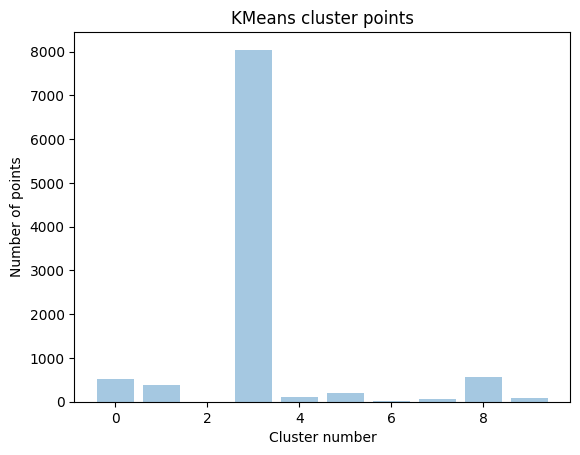

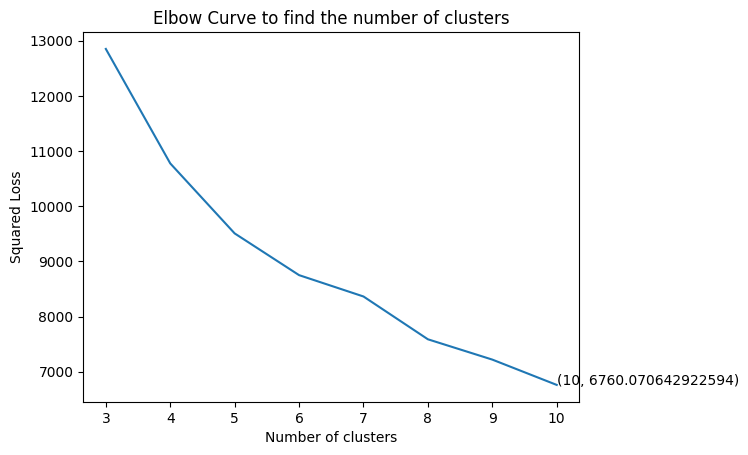

The optimal number of clusters obtained is - 10
The loss for the optimal cluster is - 6760.070642922594
Silhouette Score for KMeans with Word2Vec: 0.2074874195034452
Silhouette Score for DBSCAN: 0.32076595266122365


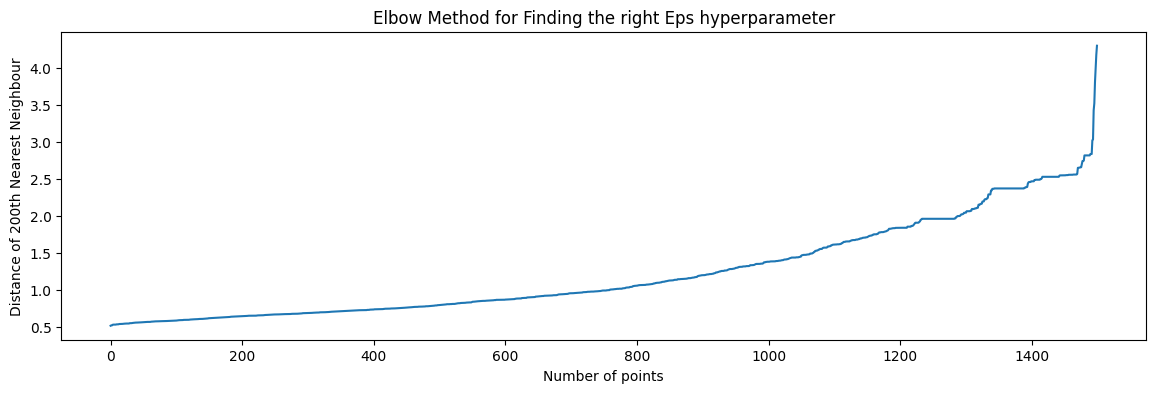

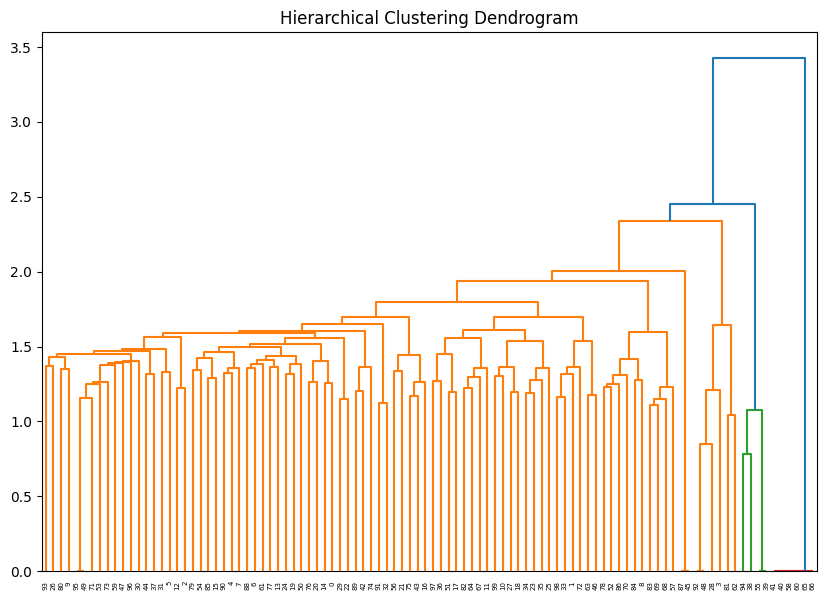

Silhouette Score for Hierarchical Clustering: 0.11170764868750732


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Silhouette Score for KMeans with BERT: 0.07718056


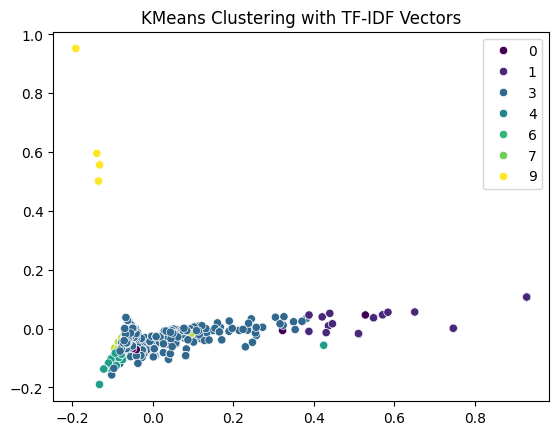

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# loading the dataset
data = pd.read_csv("Amazon_Unlocked_Mobile.csv", low_memory=False)
#dropping the rows with missing reviews
data = data.dropna(subset=['Reviews'])
reviews = data['Reviews'].values[:9900]

#text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

try:
    reviews = [preprocess_text(review) for review in reviews]
except LookupError:
    nltk.download('punkt_tab')  # Download the punkt tokenizer data
    reviews = [preprocess_text(review) for review in reviews]

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(reviews)

# K-means clustering with TF-IDF
model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(X_tfidf)
labels_tf = model_tf.labels_
print("Silhouette Score for KMeans with TF-IDF:", silhouette_score(X_tfidf, labels_tf))
print("Top terms per cluster:")
terms1 = vectorizer.get_feature_names_out()
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
    print()

# Plot number of points in each cluster for K-means with TF-IDF
plt.bar([x for x in range(10)], np.bincount(labels_tf), alpha=0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()
sentences = [review.split() for review in reviews]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

X_word2vec = np.array([get_sentence_vector(review, word2vec_model) for review in reviews])
num_clus = [x for x in range(3, 11)]
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters=cluster, random_state=42).fit(X_word2vec)  #training cluster
    squared_errors.append(kmeans.inertia_)

optimal_clusters = np.argmin(squared_errors) + 3  #finding number for optimal cluster
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Squared Loss")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()

print("The optimal number of clusters obtained is -", optimal_clusters)
print("The loss for the optimal cluster is -", min(squared_errors))

# K-means with Word2Vec
kmeans_w2v = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_w2v_labels = kmeans_w2v.fit_predict(X_word2vec)
print("Silhouette Score for KMeans with Word2Vec:", silhouette_score(X_word2vec, kmeans_w2v_labels))

# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_word2vec)
if len(set(dbscan_labels)) > 1:
    print("Silhouette Score for DBSCAN:", silhouette_score(X_word2vec, dbscan_labels))
else:
    print("Silhouette Score for DBSCAN: N/A (only one cluster)")

minPts = 2 * 100
twohundrethneigh = []
for val in X_word2vec[:1500]:
    distances = np.linalg.norm(X_word2vec[:1500] - val, axis=1)
    distances.sort()
    twohundrethneigh.append(distances[199])
twohundrethneigh.sort()

plt.figure(figsize=(14, 4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()
linked = linkage(X_tfidf.toarray()[:100], 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()
hierarchical_labels = fcluster(linked, t=5, criterion='maxclust')
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(X_tfidf[:100].toarray(), hierarchical_labels))

# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_bert = np.array([get_bert_embedding(review) for review in reviews[:100]])
kmeans_bert = KMeans(n_clusters=5, random_state=42)
kmeans_bert_labels = kmeans_bert.fit_predict(X_bert)
print("Silhouette Score for KMeans with BERT:", silhouette_score(X_bert, kmeans_bert_labels))
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray()[:1000])
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_tf[:1000], palette='viridis')
plt.title('KMeans Clustering with TF-IDF Vectors')
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

1. K-means: Recommended for cases which it is easier to define manageable, spherical groups. There are also a significant draw back; its results have a strong relation to the initial position of centroids and the number of clusters to be formed which require prior designation.
2. DBSCAN: Best used for finding clusters of any shape that is arbitrary and to recognize noise data points. Nevertheless, it scored higher when it came to non-uniform data densities compared to k-means.
3. Hierarchical Clustering: Splitted the data into groups based on dendrogram hence helpful in revealing clusters interrelations only but not so efficient for large data sets.
4. Word2Vec: Produced dense meanings of words which importantly improved some classic models such as Random Forest.
5. BERT: Used contextual word representations which were the best performers among the others in many subsequent operations especially in terms of accuracy and semantic depth.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:
The task was a very through NLP—every model provided different and valuable information, starting with the
simplest TF-IDF and finishing with the details of Word2Vec and BERT embeddings. It focused on the advantage
and difference in techniques and demonstrated the development of text classification.




'''